# Imports 

In [1]:
import numpy as np
from PIL import Image
import time
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
# set things up for images display
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

### Tensorflow and Keras

In [2]:
import tensorflow as tf


from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

### Initial Image to work with 

In [8]:
content_path = './tmp/nst/cot.jpg'
style_path = './tmp/nst/style.jpg'

### Preprocessing the Image 

In [9]:
def load_image(path_to_image):
    max_dimension = 512
    image = Image.open(path_to_image)
    longest_side = max(image.size)
    scale = max_dimension/longest_side
    image = image.resize((round(image.size[0]*scale), round(image.size[1]*scale)), Image.ANTIALIAS)

    image = kp_image.img_to_array(image) 
    
    image = np.expand_dims(image, axis=0)
    return image




    
    
    
    

In [10]:
def show_image(image, title=None):
    image1 = np.squeeze(image, axis=0)
  
    image1 = image1.astype('uint8')
    plt.imshow(image1)
    if title is not None:
        plt.title(title)
    plt.imshow(image1)
 

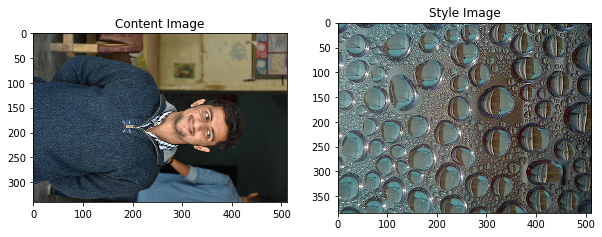

In [11]:
channel_means = [103.939, 116.779, 123.68] 
plt.figure(figsize=(10,10))
content_image = load_image(content_path).astype('uint8')
style_image = load_image(style_path).astype('uint8')
plt.subplot(1, 2, 1)
show_image(content_image, 'Content Image')
plt.subplot(1, 2, 2)
show_image(style_image, 'Style Image')
plt.show()

### Proccessing image according to VGG 19 

In [12]:
def load_and_process_image(path_to_image):
    image = load_image(path_to_image)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

In [13]:
def deprocess_image(processed_image):
    im = processed_image.copy()
    if len(im.shape) == 4:
        im = np.squeeze(im, 0)
    assert len(im.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(im.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

  
    im[:, :, 0] += channel_means[0] 
    im[:, :, 1] += channel_means[1]
    im[:, :, 2] += channel_means[2]
    im= im[:, :, ::-1] # channel last

    im = np.clip(im, 0, 255).astype('uint8')
    return im

In [14]:
# The feature maps are obtained from this content layer
content_layers = ['block5_conv2']

# Style layers we need
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

number_of_content_layers = len(content_layers)
number_of_style_layers = len(style_layers)


###  Getting model

In [15]:
def get_model():
    vgg_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False

    # Get output layers corresponding to style and content layers
    style_outputs = [vgg_model.get_layer(name).output for name in style_layers]
    content_outputs = [vgg_model.get_layer(name).output for name in content_layers]

    model_outputs = style_outputs + content_outputs
    # Build model
    return models.Model(vgg_model.input, model_outputs)

In [16]:
def rms_loss(image1,image2):
    loss = tf.reduce_mean(input_tensor=tf.square(image1 - image2))
    return loss

In [17]:
def content_loss(content, target):
    return rms_loss(content, target)

In [18]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1]) # channels is last dimension
    tensor = tf.reshape(input_tensor, [-1, channels])  # Make the image channels first
    number_of_channels = tf.shape(input=tensor)[0]
    gram = tf.matmul(tensor, tensor, transpose_a=True)
    return gram / tf.cast(number_of_channels, tf.float32)

In [19]:
def style_loss(style, gram_target):
    gram_style = gram_matrix(style)
    return rms_loss(gram_style, gram_target) 


In [20]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_image(content_path)
    content_outputs = model(content_image)
  
    content_features = [content_layer[0] for content_layer in content_outputs[number_of_style_layers:]]


    style_image = load_and_process_image(style_path)
    style_outputs = model(style_image)
    style_features = [style_layer[0] for style_layer in style_outputs[:number_of_style_layers]]

    return style_features, content_features
     

In [21]:
def compute_total_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)




    content_score = 0
    content_output_features = model_outputs[number_of_style_layers:]
    weight_per_content_layer = 1.0 / float(number_of_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer*content_loss(comb_content[0], target_content)
    content_score *= content_weight


    style_score = 0
    style_output_features = model_outputs[:number_of_style_layers]
    weight_per_style_layer = 1.0 / float(number_of_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer *style_loss(comb_style[0], target_style)
    style_score *= style_weight


    total_loss = style_score + content_score
    return total_loss, style_score, content_score


In [22]:
def compute_grads(config):
    with tf.GradientTape() as tape:
        all_loss = compute_total_loss(**config)
 # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, config['init_image']), all_loss


In [23]:
import IPython.display

def run_style_transfer(content_path,style_path,number_of_iterations=1000,content_weight=1e3,style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

  # Get the style and content feature representations (from our specified intermediate layers)
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

      # Set initial image
    initial_image = load_and_process_image(content_path)
    initial_image = tf.Variable(initial_image, dtype=tf.float32)
      # Create our optimizer
    optimiser = tf.compat.v1.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
      #opt = tf.keras.optimizers.Adam()

      # Store our best result
    best_loss, best_image = float('inf'), None # any loss will be lesss than float('inf')

      # Create a suitable configuration
    loss_weights = (style_weight, content_weight)
    config = {
          'model': model,
          'loss_weights': loss_weights,
          'init_image': initial_image,
          'gram_style_features': gram_style_features,
          'content_features': content_features
      }

      # For displaying
    number_rows = 2
    number_cols = 5
    display_interval = number_of_iterations/(number_rows*number_cols)

    norm_means = np.array(channel_means)
    minimum_vals = -norm_means
    maximum_vals = 255 - norm_means
    images = []
    for i in range(number_of_iterations):
        grads, all_loss = compute_grads(config)
        loss, style_score, content_score = all_loss
        optimiser.apply_gradients([(grads, initial_image)])
        clipped_image = tf.clip_by_value(initial_image, minimum_vals, maximum_vals)
        initial_image.assign(clipped_image)

        if loss < best_loss:
            best_loss = loss
            best_image = deprocess_image(initial_image.numpy()) # this is one place where we need eager execution

        if i % display_interval== 0:
            plot_image = initial_image.numpy()
            plot_image = deprocess_image(plot_image)
            images.append(plot_image)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_image))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e} '
                  .format(loss, style_score, content_score))

    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,image in enumerate(images):
        plt.subplot(number_rows,number_cols,i+1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

    return best_image, best_loss

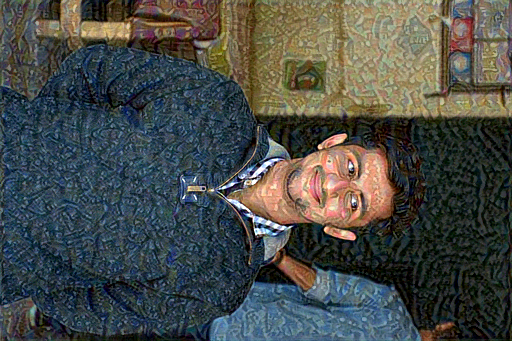

Iteration: 10
Total loss: 1.4155e+07, style loss: 1.2437e+07, content loss: 1.7186e+06 


In [ ]:
best_image, best_loss = run_style_transfer(content_path, style_path, number_of_iterations=100)

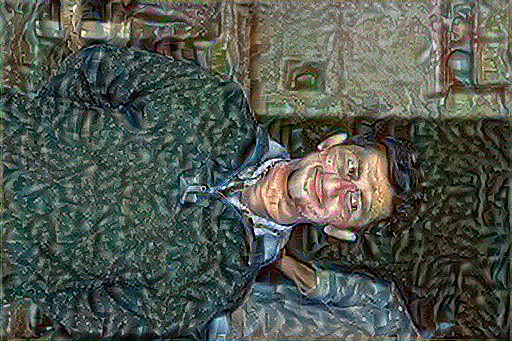

In [68]:
Image.fromarray(best_image)

In [69]:
def show_results(best_image, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_image(content_path)
    style = load_image(style_path)

    plt.subplot(1, 2, 1)
    show_image(content, 'Content Image')

    plt.subplot(1, 2, 2)
    show_image(style, 'Style Image')

    if show_large_final:
        plt.figure(figsize=(10, 10))

        plt.imshow(best_image)
        plt.title('Output Image')
        plt.show()

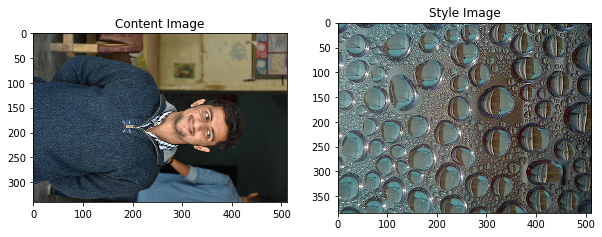

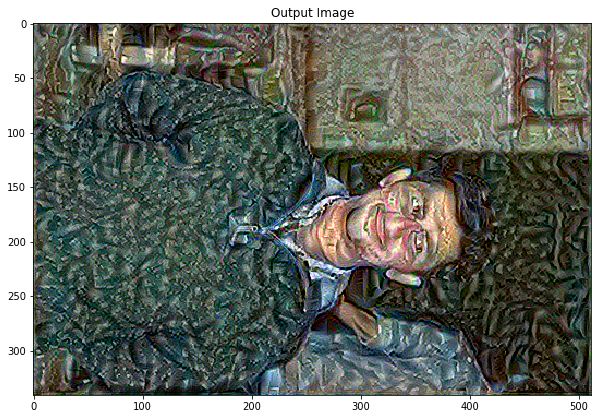

In [70]:
show_results(best_image, content_path, style_path)